In [1]:
import asrtoolkit
from asrtoolkit import wer, cer
import cv2
import io
from fuzzywuzzy import fuzz, process
import numpy as np
from PIL import Image
import pytesseract
import sys
from skimage import io as ioski
from skimage.color import rgb2gray
from skimage.transform import rotate, resize
import os
from google.cloud import vision_v1
from google.cloud.vision_v1 import types
from dotenv import load_dotenv, find_dotenv
load_dotenv()

False

In [2]:
credential_path = 'F:\\Lecture notes\\Sem-8\\MP(8)\\Code\\dizitizationofhinditext-4073208d099d.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

In [3]:
client = vision_v1.ImageAnnotatorClient()

In [4]:
dirpath = os.getcwd()  # os abosulute current directory path
print("This Directory", dirpath)
parentDirectory = os.path.dirname(dirpath)
print(parentDirectory)
GrandparentDirectory = os.path.dirname(parentDirectory)
print(GrandparentDirectory)

This Directory f:\Lecture notes\Sem-8\MP(8)\Code
f:\Lecture notes\Sem-8\MP(8)
f:\Lecture notes\Sem-8


In [5]:
imagePath = parentDirectory + '\\Resources\\shimage.jpg'


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2075x1760 at 0x1D6E8178D30>


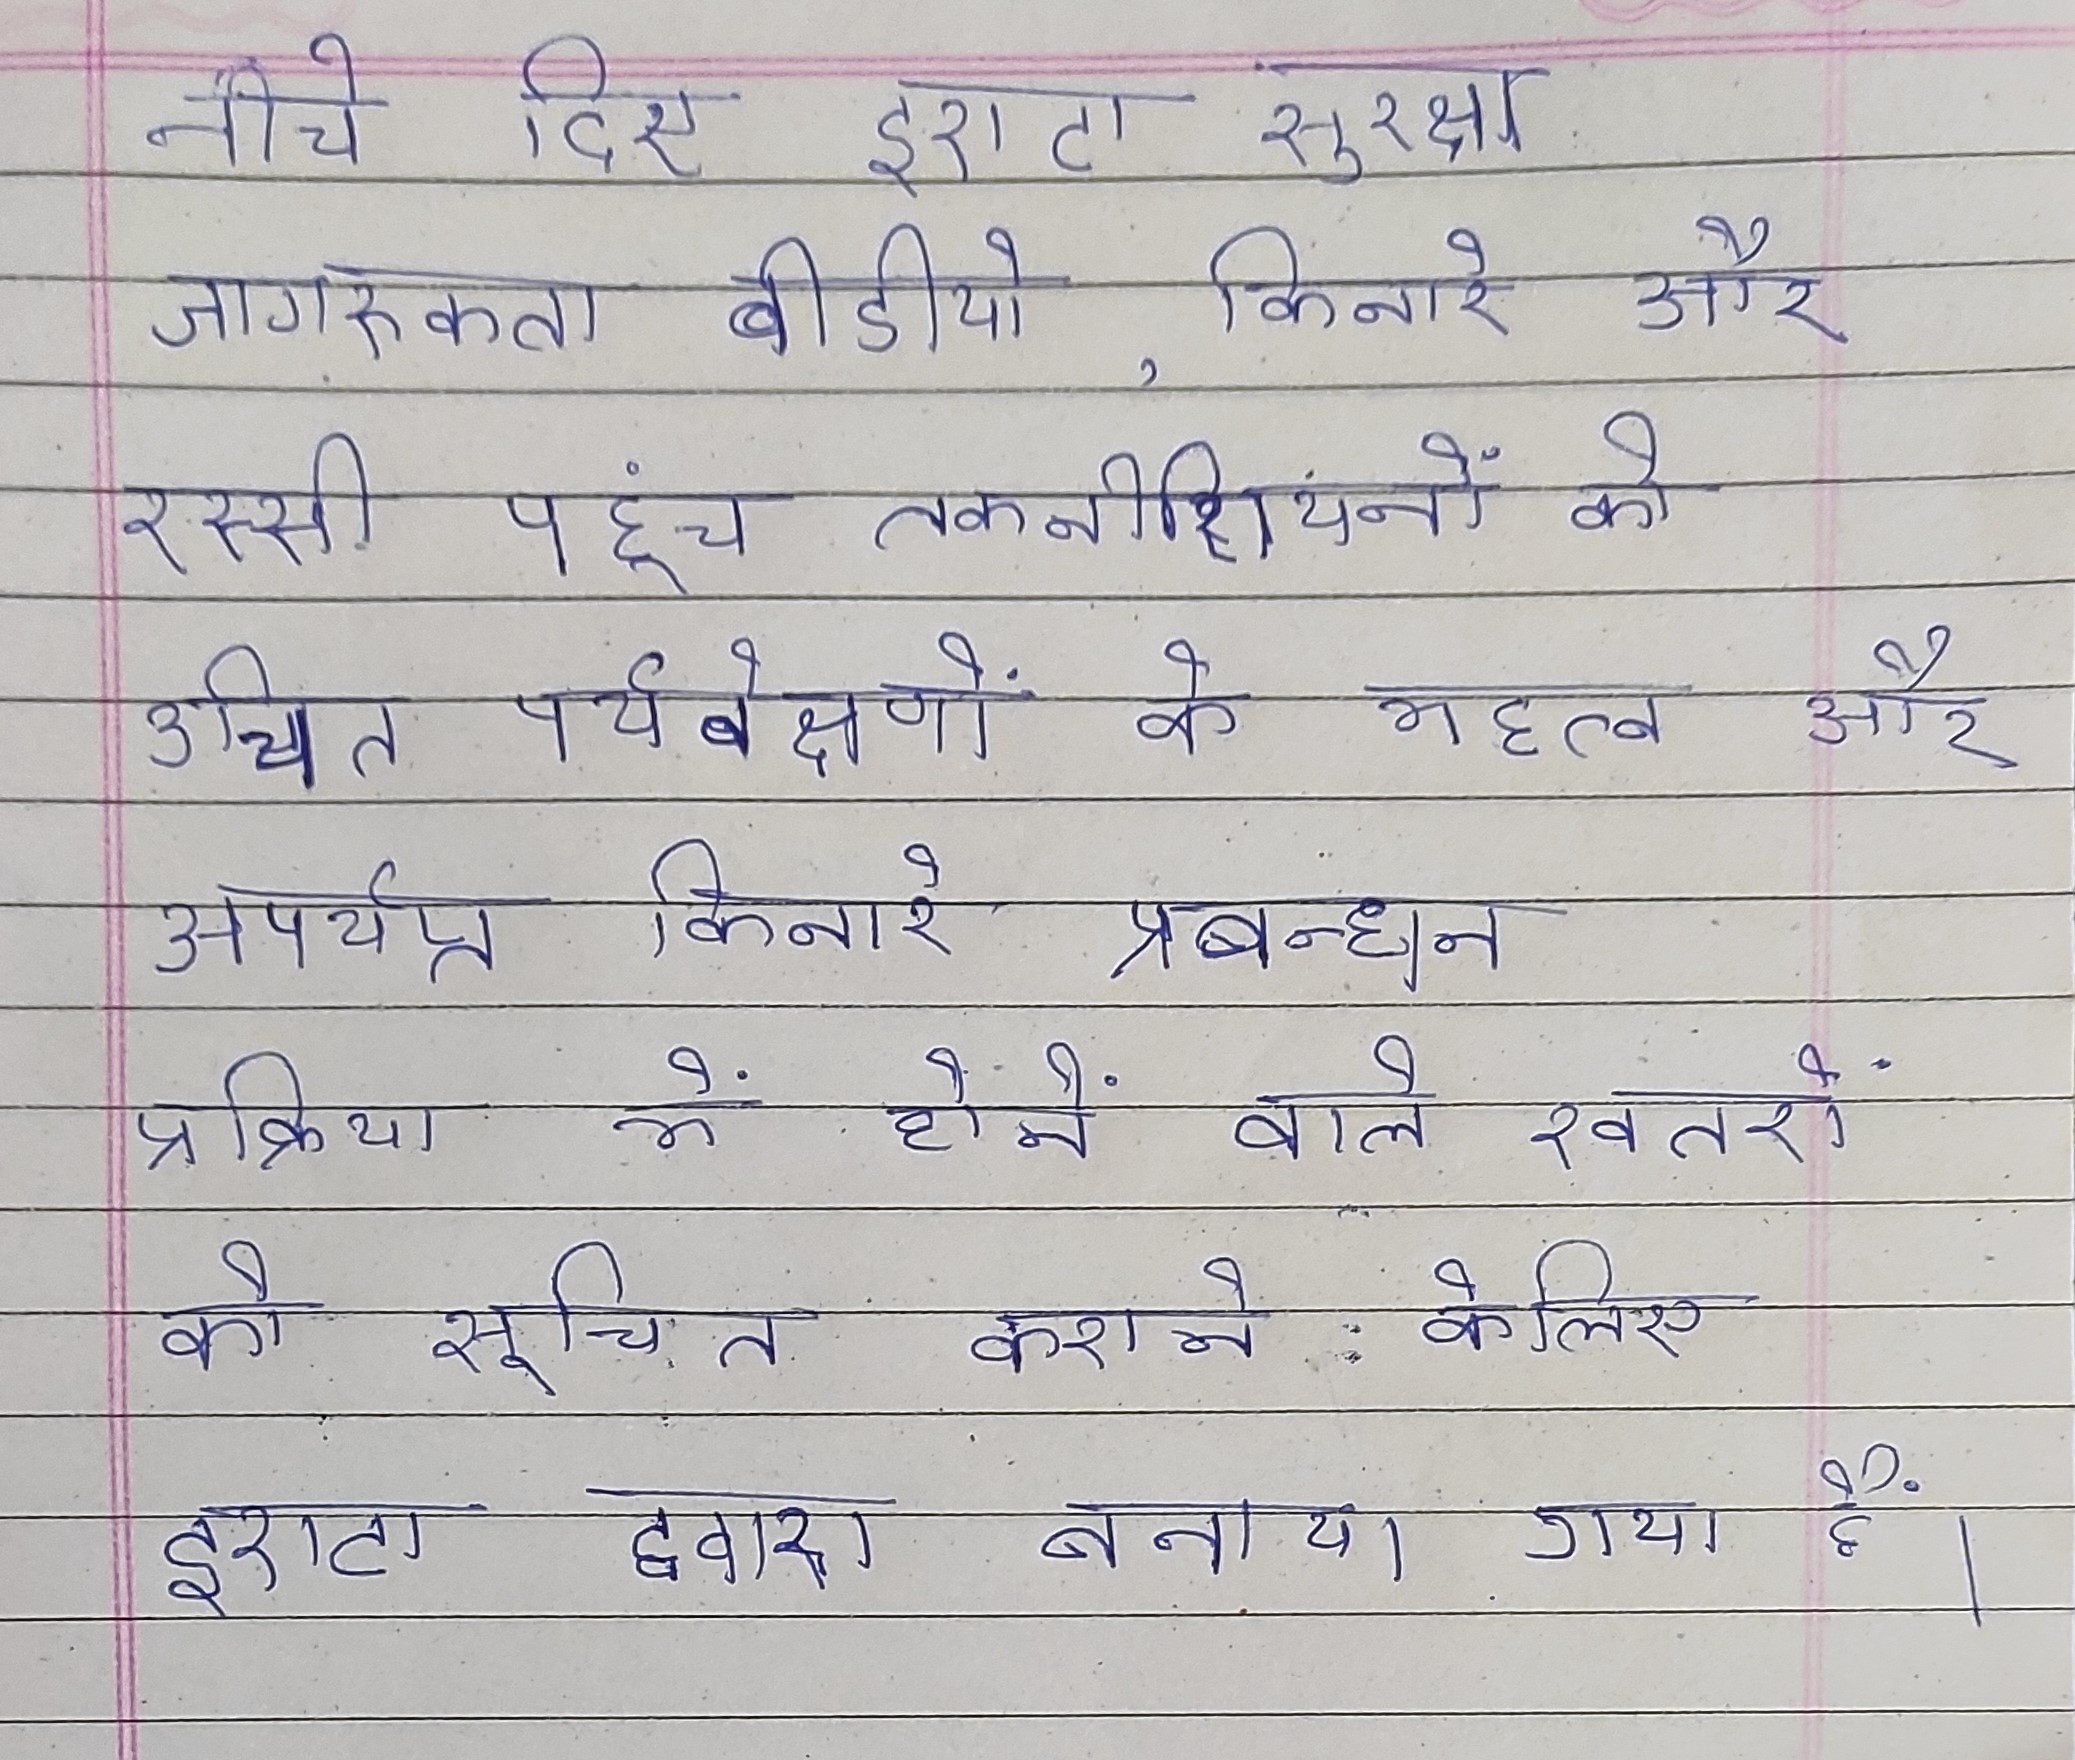

In [6]:
opImg = Image.open(imagePath)
print(opImg)
opImg

In [7]:
from deskew import determine_skew

In [8]:
image = ioski.imread(imagePath)
grayscale = rgb2gray(image)
angle = determine_skew(grayscale)
print(angle)
rotated = rotate(image, angle, resize=True) * 255
print(type(rotated))
ioski.imsave(parentDirectory + "\\Resources\\output_deskewed.png", rotated.astype(np.uint8))


0.0
<class 'numpy.ndarray'>


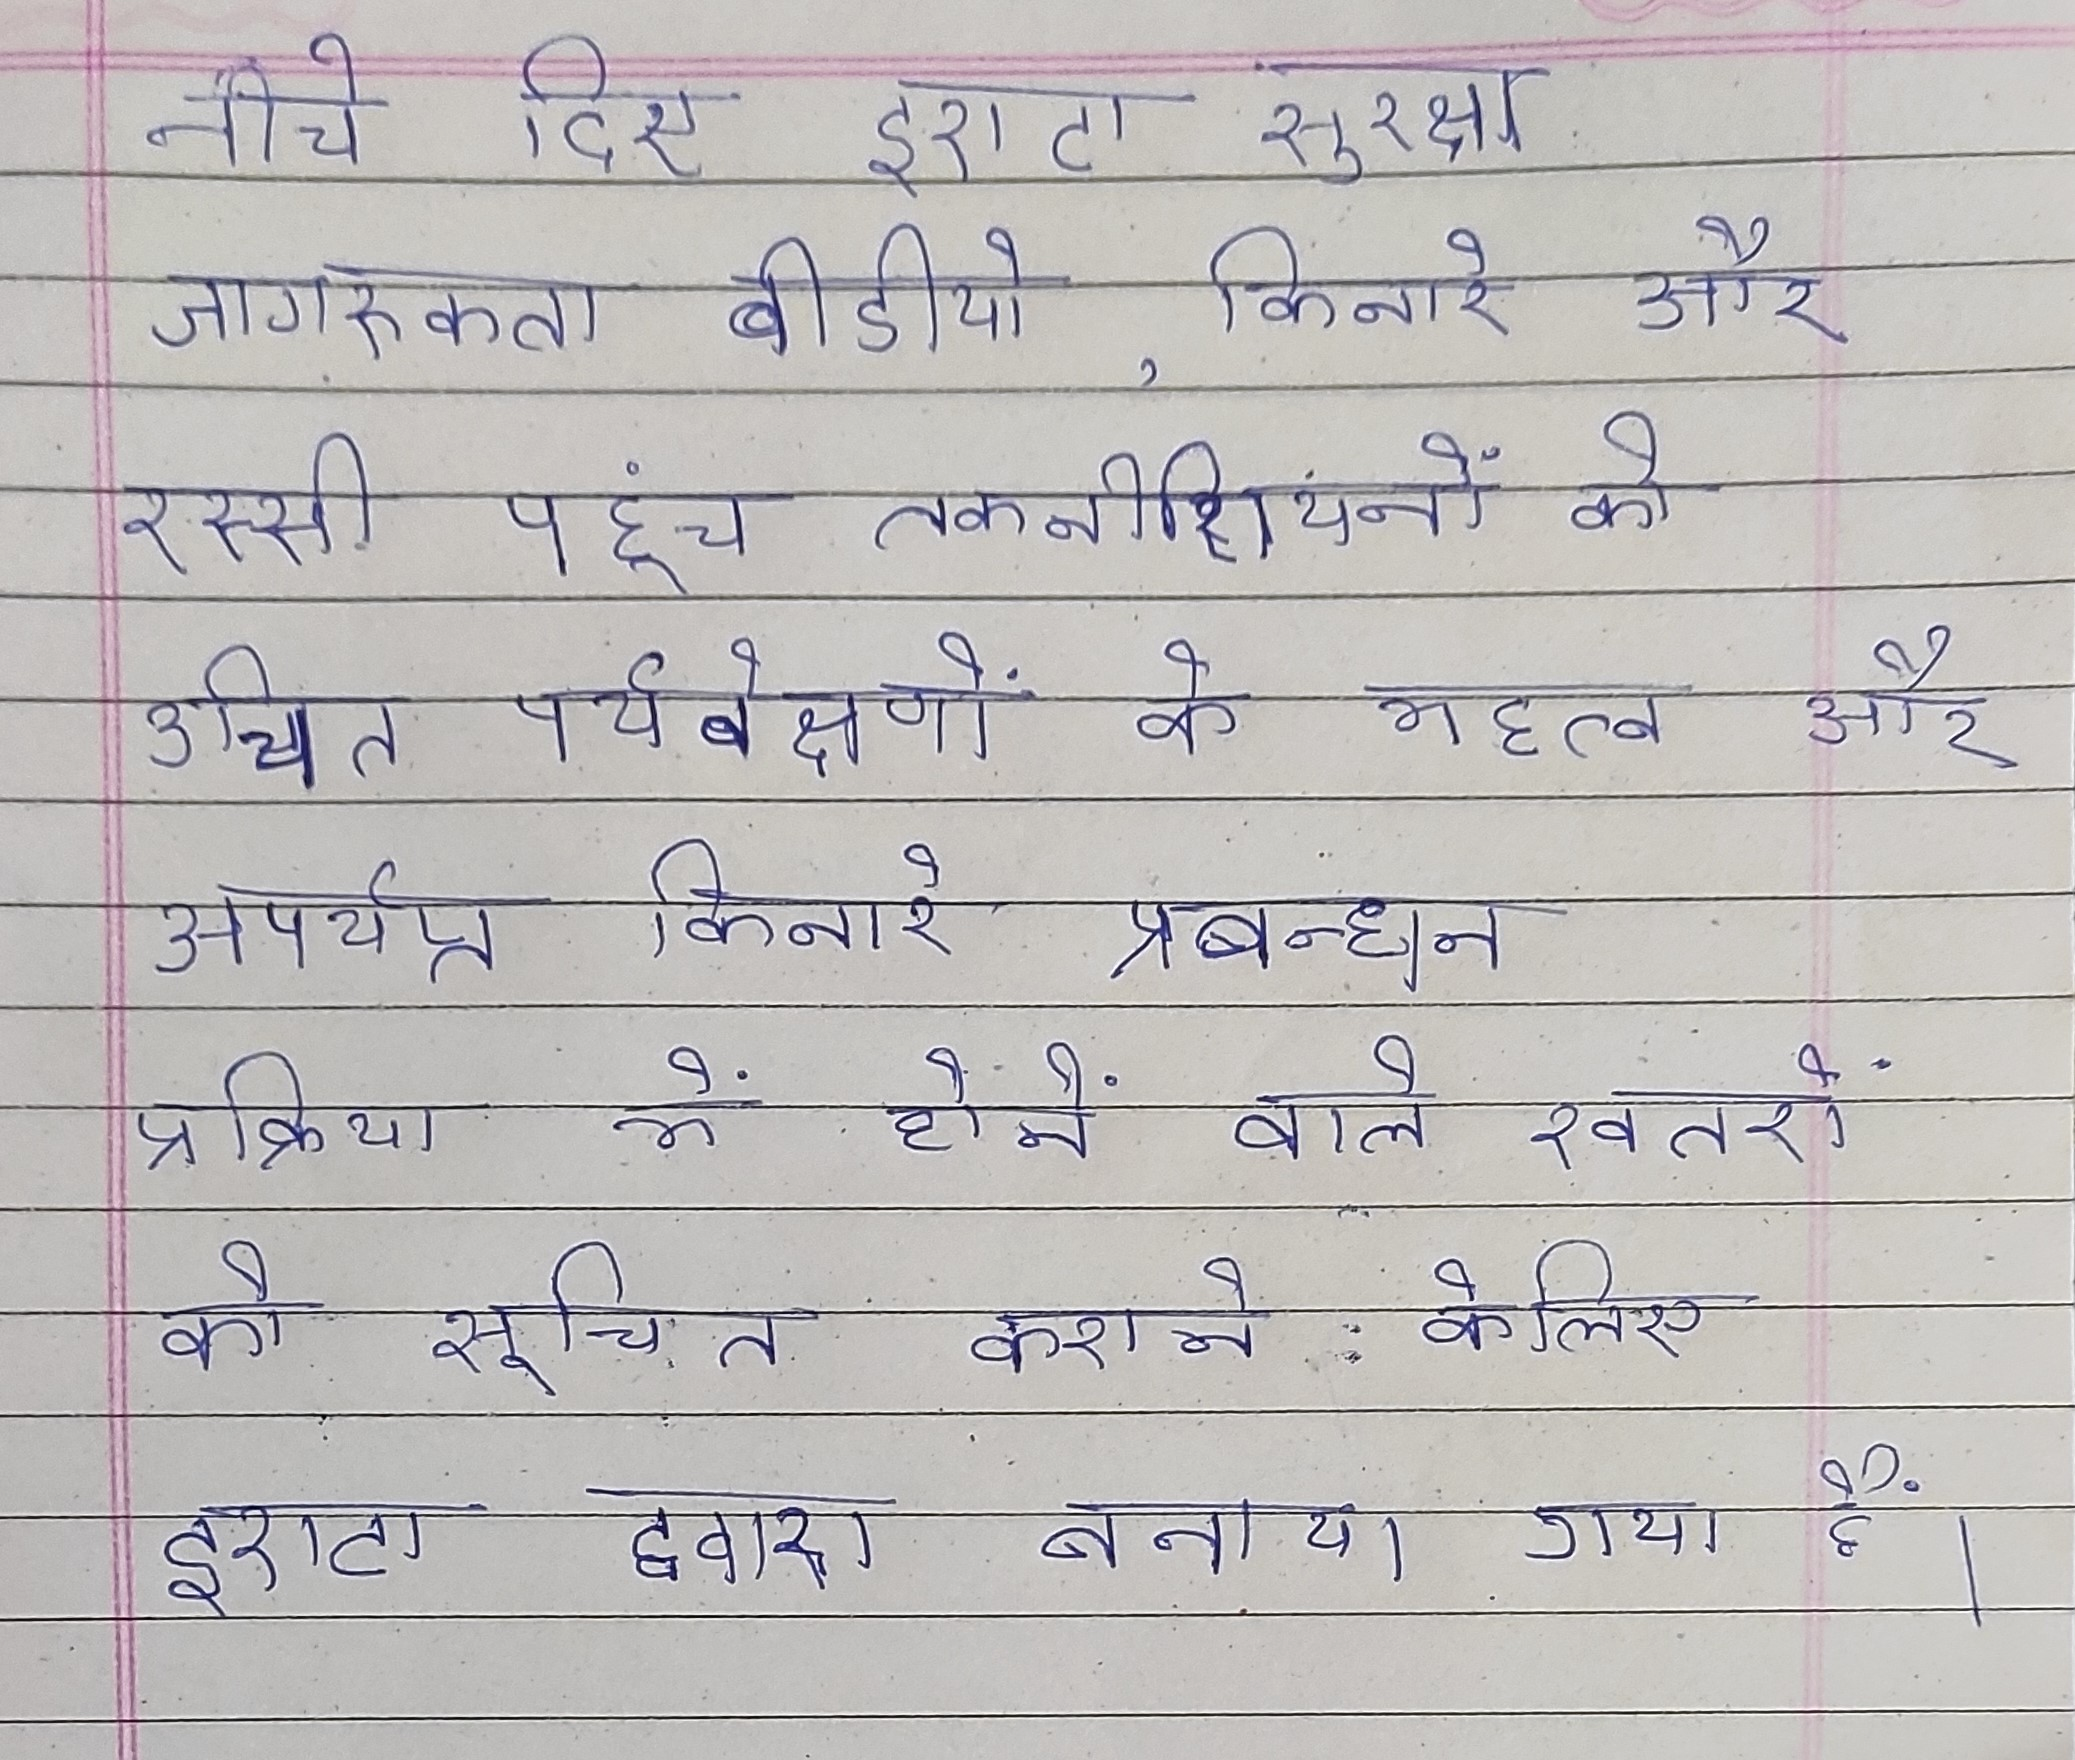

In [9]:
deskewedImagePath = parentDirectory + "\\Resources\\output_deskewed.png"
Image.open(deskewedImagePath)

In [19]:
def pre_process_image(image):
    """This function will pre-process a image with: cv2 & deskew
    so it can be process by tesseract"""
    img = cv2.imread(image)
    img = cv2.resize(img, None, fx=.3, fy=.3) #resize using percentage
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #change color format from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #format image to gray scale
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 11) #to remove background
    return img

In [10]:
image = cv2.imread(deskewedImagePath)
image = cv2.resize(image, None, fx=.3, fy=.3)
cv2.imshow("img", image)
cv2.waitKey()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imshow("img", gray)
cv2.waitKey()
thresh = cv2.threshold(gray, 125, 255, cv2.THRESH_BINARY_INV)[1]
cv2.imshow("img", thresh)
cv2.waitKey()


-1

In [15]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
dilate = cv2.dilate(opening, kernel, iterations=1)
cv2.imshow("img", dilate)
cv2.waitKey()

-1

In [16]:
# Find contours and remove small noise
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 50:
        cv2.drawContours(dilate, [c], -1, 0, -1)
cv2.imshow("img", dilate)
cv2.waitKey()


-1

In [17]:
result = 255 - dilate
result = cv2.GaussianBlur(result, (3, 3), 0)
cv2.imshow("img", result)
cv2.waitKey()


-1

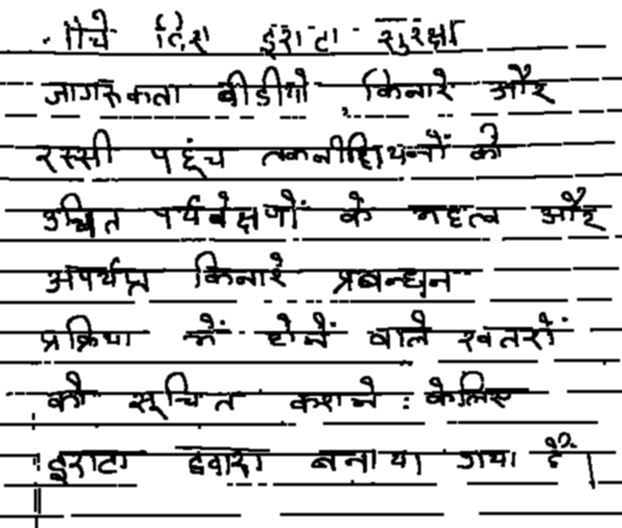

In [20]:
processedImage = pre_process_image(parentDirectory + "\\Resources\\output_deskewed.png")
cv2.imwrite(parentDirectory + "\\Resources\\output_processed.png", result)
Image.open(parentDirectory + "\\Resources\\output_processed.png")

In [22]:
detectTextPath = parentDirectory + "\\Resources\\output_processed.png"
ground_truth = "भारत–भूमि की महानता उसकी विशाल जनसंख्या अथवा भू–क्षेत्र के कारण नहीं अपितु उसकी भव्य और अनुकरणीय उदार परम्पराओं के कारण रही है।"


In [23]:
hypothesis0 = pytesseract.image_to_string(detectTextPath, lang='hin')
print("CER, WER, Rate :", cer(ground_truth, hypothesis0), wer(ground_truth, hypothesis0), fuzz.ratio(ground_truth, hypothesis0))
print(hypothesis0)

CER, WER, Rate : 140.0 179.06976744186048 27
_ -गोचे दिए इशटा शाउक्षा
जाएरि, कला बीडीशो +किनारे खीॉशूए
)-चहं- धल्पौल्लौए7एः
>जक्षित नर्वबेक्षणों- के शधटत्त- आटा,
7 अपर्थप्न क्विन्गरै- जन्नन्धना
“फ्रक्रिम्गा- लक न्क्कैन्तै बाले एबतरौो ः
नक्‍के। स््किता कशन्तैः जैलिेशाण एप:
जम आज का ब्वसा या छाया नह




In [24]:
detectTextPath = parentDirectory + "\\Resources\\output_processed.png"

In [25]:
with io.open(detectTextPath, 'rb') as image_file:
    content = image_file.read()

image_v = vision_v1.types.Image(content=content)
response = client.document_text_detection(image=image_v)
docText = response.full_text_annotation.text
hypothesis5 = docText
print("CER, WER, Rate :", cer(ground_truth, hypothesis5), wer(ground_truth, hypothesis5), fuzz.ratio(ground_truth, hypothesis5))
print(hypothesis5)
print(ground_truth)


CER, WER, Rate : 106.36363636363636 153.48837209302326 32
गोचे दिए ईराटा सुरक्षा
जागरुकता बीडीयो किनारे और
रस्सी पहुंच तकनीशियनों को
उचित पर्यवेक्षणों के महत्व औ
अपर्याप्त किनारे प्रबन्धन
प्रक्रिया में होने वाले खतरों
को सूचित कराने के लिए
:
इराटा
गया हैर
हवारी बनाया गया
भारत–भूमि की महानता उसकी विशाल जनसंख्या अथवा भू–क्षेत्र के कारण नहीं अपितु उसकी भव्य और अनुकरणीय उदार परम्पराओं के कारण रही है।


In [167]:
# Python code to create a file
with open('output.txt', "w", encoding="utf-8") as f:
    f.write(hypothesis5)
f.close()